### 데이터 로드 및 전처리

- reuters 데이터셋을 로드하고, 훈련 데이터셋을 25%를 검증 데이터셋으로 분리한다.
- 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한

In [1]:
# 사용할 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터로 사용
(train_data_full, train_labels_full), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data_full, train_labels_full,
                                                                  test_size=0.25,
                                                                  random_state=123)


# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


- 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행한다.

In [3]:
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들을 범주형 형태로 to_categorical() 함수를 사용해 변환한다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

### 모델 구성 및 컴파일

- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성한다.

In [5]:
model = models.Sequential()
model.add(layers.Dense(32, input_shape=(10000, )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

### 모델 학습

- ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행한다.

In [6]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data = (x_val, y_val),
                    callbacks=(checkpoint, earlystop))

Epoch 1/20
14/14 [==============================] - 2s 51ms/step - loss: 3.7169 - accuracy: 0.1568 - val_loss: 3.5045 - val_accuracy: 0.5864
Epoch 2/20
14/14 [==============================] - 0s 15ms/step - loss: 2.8751 - accuracy: 0.3621 - val_loss: 3.2520 - val_accuracy: 0.6233
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 2.4536 - accuracy: 0.4926 - val_loss: 3.0034 - val_accuracy: 0.6367
Epoch 4/20
14/14 [==============================] - 0s 17ms/step - loss: 2.1392 - accuracy: 0.5720 - val_loss: 2.7642 - val_accuracy: 0.6354
Epoch 5/20
14/14 [==============================] - 0s 17ms/step - loss: 1.8866 - accuracy: 0.6237 - val_loss: 2.5214 - val_accuracy: 0.6429
Epoch 6/20
14/14 [==============================] - 0s 17ms/step - loss: 1.6765 - accuracy: 0.6652 - val_loss: 2.3182 - val_accuracy: 0.6429
Epoch 7/20
14/14 [==============================] - 0s 16ms/step - loss: 1.5484 - accuracy: 0.6827 - val_loss: 2.1452 - val_accuracy: 0.6447
Epoch 8/20
14

- 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화

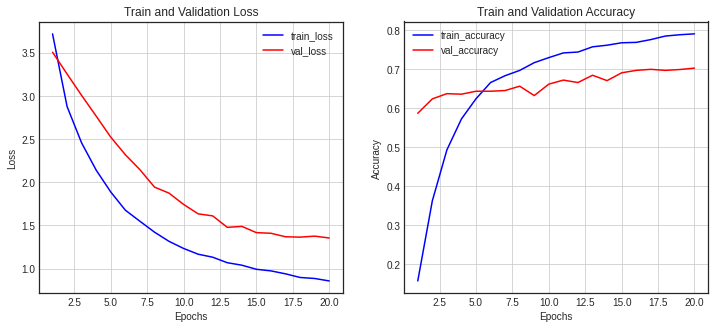

In [7]:
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측

- 테스트 데이터셋을 이용해 모델을 평가한다.

In [8]:
model.evaluate(x_test, y_test, verbose=1)

71/71 [==============================] - 0s 3ms/step - loss: 1.3160 - accuracy: 0.7119


[1.3159514665603638, 0.7119323015213013]